In [16]:
import os
import sys

module_path = os.path.abspath(os.path.join('../ipsim'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ipsim import *

import numpy as np
import pandas as pd


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [17]:
class ECSRTTest:
    Ea  = 72750     # activation energy J/gmol
    R   = 8.314     # gas constant J/gmol/K
    k0  = 7.2e10    # Arrhenius rate constant 1/min
    dHr = -5.0e4    # Enthalpy of reaction [J/mol]
    rho = 1000.0    # Density [g/L]
    Cp  = 0.239     # Heat capacity [J/g/K]
    UA  = 5.0e4     # Heat transfer [J/min/K]
    
    V   = 100.0     # Volume [L]
    q   = 100.0     # Flowrate [L/min]
    cAi = 1.0       # Inlet feed concentration [mol/L]
    Ti  = 350.0     # Inlet feed temperature [K]
    Tc  = 300.0     # Coolant temperature [K]

    cA0 = 0.5;      # Initial concentration [mol/L]
    T0  = 350.0;    # Initial temperature [K]
    
    def k(T):
        return ECSRTTest.k0*np.exp(-ECSRTTest.Ea/ECSRTTest.R/T)

In [18]:
class ExothermicContinuousStirredTankReactor0(ProcessNode):
    def __init__(self, name, *, cA0 = ECSRTTest.cA0, T0 = ECSRTTest.T0, V = ECSRTTest.V
                , dHr = ECSRTTest.dHr, rho = ECSRTTest.rho, Cp=ECSRTTest.Cp,UA = ECSRTTest.UA):
        super().__init__(name)
        self._cA = cA0
        self._T = T0
        self._V = V
        self._dHr = dHr
        self._rho=rho
        self._Cp = Cp
        self._UA = UA
        self.create_input("q")
        self.create_input("cAi")
        self.create_input("Ti")
        self.create_input("Tc")
        self.create_output("cA")
        self.create_output("T")
    
    def evaluate(self):
        i = self.inputs()
        q   = i["q"]()
        cAi = i["cAi"]()
        Ti  = i["Ti"]()
        Tc  = i["Tc"]()
        cA  = self._cA
        T   = self._T
        
        kcA = ECSRTTest.k(T)*cA
        dt = self._model.dt()

        qV    = q/self._V
        dHpC  = -self._dHr/(self._rho*self._Cp)
        UAVpC = self._UA/(self._V*self._rho*self._Cp)
     
        _dcA  = (qV*(cAi-cA) - kcA)*dt
        _dT  = (qV*(Ti-T)+dHpC*kcA+UAVpC*(Tc-T))*dt
        cA = cA + _dcA
        T  = T  + _dT
        
        self._cA = cA
        self._T = T

        self.set_result("cA",cA)
        self.set_result("T",T)

In [19]:
def prepare_model():    
    processModel = ProcessModel("test",dt=0.005)
    processModel.add_node(ProcessInputNode("InletFeed", {"q":100,"cAi":1,"Ti":350}))
    processModel.add_node(ProcessInputNode("Coolant", {"Tc":290}))
    processModel.add_node(ExothermicContinuousStirredTankReactor0("ECSTR"))
    processModel.bond_nodes("ECSTR","q","InletFeed","q")
    processModel.bond_nodes("ECSTR","cAi","InletFeed","cAi")
    processModel.bond_nodes("ECSTR","Ti","InletFeed","Ti")
    processModel.bond_nodes("ECSTR","Tc","Coolant","Tc")
    
    return processModel

In [20]:
class RollingMean(object):
    def __init__(self, window_size):
        self.window_size = window_size
        self.buffer = []
        self._mean = 0

    def mean(self):
        return self._mean

    def add(self, v):
        if(len(self.buffer) == self.window_size):
            self._mean = (self._mean*self.window_size - self.buffer[0]+v)/self.window_size
            self.buffer.pop(0)
            self.buffer.append(v)
        else:
            self.buffer.append(v)
            self._mean = sum(self.buffer)/len(self.buffer)

In [21]:
def show_model_statistics(y, y_pred):
    f_metrics = {"Accuracy":accuracy_score
                ,"Precision":precision_score
                ,"Recall":recall_score
                ,"F1" : f1_score
                ,"Cohens kappa": cohen_kappa_score
                ,"ROC AUC": roc_auc_score
                ,"Confusion matrix": confusion_matrix}
    for metric in f_metrics:
        try:
            print(metric, f_metrics[metric](y,y_pred))
        except Exception as e:
            print(f"Metiric {metric}: {e}")

In [22]:
def prepare_data_flowrate(process_model, points_count,*,skip_iteration=0, pivots = 1):
    actual_points = points_count - skip_iteration
    x = np.empty((actual_points,2))
    y = np.empty((actual_points,1),dtype=np.dtype('B'))

    if skip_iteration > 0:
        for _ in range(skip_iteration):
            state = process_model.next_state(("ECSTR",))

    pivot_leght = int(actual_points/(pivots+1))
   
    for _ in range(actual_points):
        state = process_model.next_state(("ECSTR",))
        cA = state['ECSTR']['cA']
        T  = state['ECSTR']['T']

        if (_ > 0) and (_ % pivot_leght) == 0:
            inode = process_model.nodes()["InletFeed"]
            flowfate = inode.value("q")*0.5
            inode.change_value("q",flowfate)
            print(f"{_} new flowrate {flowfate}")

        x[_] = cA, T
        y[_] = 1 if ((cA > 0.8) and (T < 350)) else 0

    return x, y

In [23]:
def prepare_data_coolant_temperature(process_model, points_count,*,skip_iteration=0, pivots = 1):
    actual_points = points_count - skip_iteration
    x = np.empty((actual_points,2))
    y = np.empty((actual_points,1),dtype=np.dtype('B'))

    rmCa = RollingMean(50)
    rmT  = RollingMean(50)
    if skip_iteration > 0:
        for _ in range(skip_iteration):
            state = process_model.next_state(("ECSTR",))
            rmCa.add(state['ECSTR']['cA'])
            rmT.add(state['ECSTR']['T'])

    pivot_leght = int(actual_points/(pivots+1))
   
    for _ in range(actual_points):
        state = process_model.next_state(("ECSTR",))
        rmCa.add(state['ECSTR']['cA'])
        rmT.add(state['ECSTR']['T'])
        cA = rmCa.mean()
        T  = rmT.mean()

        if (_ > 0) and (_ % pivot_leght) == 0:
            inode = process_model.nodes()["Coolant"]
            Tc = 304 if inode.value("Tc") == 290 else 290
            inode.change_value("Tc",Tc)
            print(f"{_} new Coolant Temperature {Tc}")

        x[_] = cA, T
        y[_] = 1 if ((cA > 0.8) and (T < 350)) else 0

    return x, y

In [24]:
def test_ml_model(process_model, ml_model, points_count,*,skip_iteration=0, pivots = 2):
    actual_points = points_count - skip_iteration
    x     = np.empty((actual_points,2))
    y     = np.empty((actual_points,1),dtype=np.dtype('B'))
    y_pred = np.empty((actual_points,1),dtype=np.dtype('B'))
    

    rmCa = RollingMean(50)
    rmT  = RollingMean(50)
    if skip_iteration > 0:
        for _ in range(skip_iteration):
            state = process_model.next_state(("ECSTR",))
            rmCa.add(state['ECSTR']['cA'])
            rmT.add(state['ECSTR']['T'])

    pivot_leght = int(actual_points/(pivots+1))
   
    for _ in range(actual_points):
        state = process_model.next_state(("ECSTR",))
        rmCa.add(state['ECSTR']['cA'])
        rmT.add(state['ECSTR']['T'])
        cA = rmCa.mean()
        T  = rmT.mean()

        if (_ > 0) and (_ % pivot_leght) == 0:
            inode = process_model.nodes()["Coolant"]
            Tc = 304 if inode.value("Tc") == 290 else 290
            inode.change_value("Tc",Tc)
            print(f"{_} new Coolant Temperature {Tc}")

        presult = ml_model.predict([[cA, T]])[0]
        if presult == 0:
            inode = process_model.nodes()["Coolant"]
            inode.change_value("Tc",290)
            print(f"{_} fix Coolant Temperature")

        x[_] = cA, T
        y[_] = 1 if ((cA > 0.8) and (T < 350)) else 0
        y_pred[_] = presult

    return x, y, y_pred

In [25]:
def show_data(x, y, title = ""):
    fig = plt.figure(figsize=(12,3),)
    fig.suptitle(title)
    plt.subplot(1, 3, 1)
    plt.ylim(0, 1)
    plt.plot(x[:,0])
    plt.title('Concentration [mol/L]')
    plt.subplot(1, 3, 2)
    plt.ylim(200, 600)
    plt.plot(x[:,1])
    plt.title('Temperature [K]')
    plt.subplot(1, 3, 3)
    plt.ylim(-1, 2)
    plt.plot(y)
    plt.title('target')
    plt.show()

In [26]:
def train_logistic(x,y):
    model = LogisticRegression()
    model.fit(x, np.ravel(y))
    return model

In [27]:
def train_random_forest(x,y):
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(x, y.ravel())
    return model

In [28]:
def train_gradient_boostins(x,y):
    model = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0)
    model.fit(x, y.ravel())
    return model

In [29]:
def train_ada_boostins(x,y):
    model = AdaBoostClassifier(n_estimators=500, algorithm="SAMME", random_state=0)
    model.fit(x, y.ravel())
    return model

In [30]:
def train_bagging(x,y):
    model = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0)
    model.fit(x, y.ravel())
    return model

1666 new Coolant Temperature 304
3332 new Coolant Temperature 290
4998 new Coolant Temperature 304


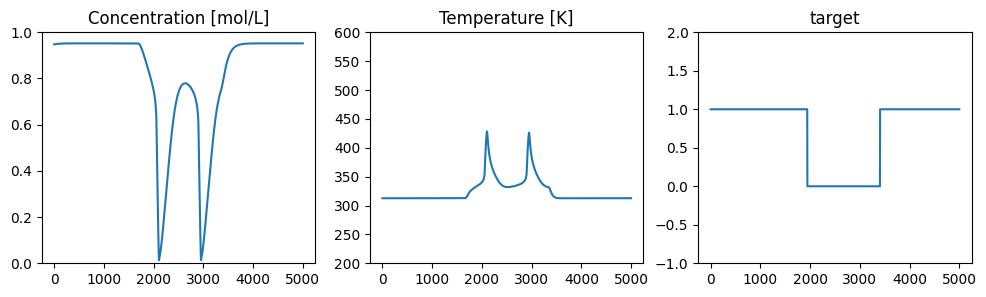

In [31]:
process_model = prepare_model()
x,y = prepare_data_coolant_temperature(process_model, 5500, skip_iteration = 500, pivots=2)
show_data(x,y)

In [32]:
models = {"logistic":train_logistic
             ,"random_forest":train_random_forest
             ,"gradient_boostins":train_gradient_boostins
             ,"ada_boostins": train_ada_boostins
             ,"bagging":train_bagging}

1666 new Coolant Temperature 304
1851 fix Coolant Temperature
1852 fix Coolant Temperature
1853 fix Coolant Temperature
1854 fix Coolant Temperature
1855 fix Coolant Temperature
1856 fix Coolant Temperature
1857 fix Coolant Temperature
1858 fix Coolant Temperature
1859 fix Coolant Temperature
1860 fix Coolant Temperature
1861 fix Coolant Temperature
1862 fix Coolant Temperature
1863 fix Coolant Temperature
1864 fix Coolant Temperature
1865 fix Coolant Temperature
1866 fix Coolant Temperature
1867 fix Coolant Temperature
1868 fix Coolant Temperature
1869 fix Coolant Temperature
1870 fix Coolant Temperature
1871 fix Coolant Temperature
1872 fix Coolant Temperature
1873 fix Coolant Temperature
1874 fix Coolant Temperature
1875 fix Coolant Temperature
3332 new Coolant Temperature 304
3517 fix Coolant Temperature
3518 fix Coolant Temperature
3519 fix Coolant Temperature
3520 fix Coolant Temperature
3521 fix Coolant Temperature
3522 fix Coolant Temperature
3523 fix Coolant Temperature
3524 f

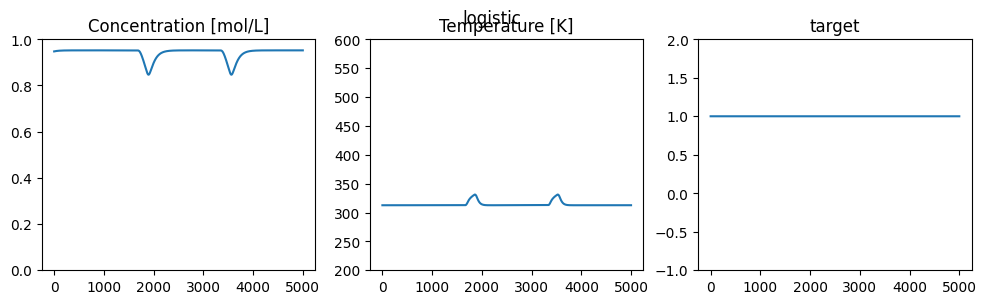

1666 new Coolant Temperature 304
1943 fix Coolant Temperature
1944 fix Coolant Temperature
1945 fix Coolant Temperature
1946 fix Coolant Temperature
1947 fix Coolant Temperature
1948 fix Coolant Temperature
1949 fix Coolant Temperature
1950 fix Coolant Temperature
1951 fix Coolant Temperature
1952 fix Coolant Temperature
1953 fix Coolant Temperature
1954 fix Coolant Temperature
1955 fix Coolant Temperature
1956 fix Coolant Temperature
1957 fix Coolant Temperature
1958 fix Coolant Temperature
1959 fix Coolant Temperature
1960 fix Coolant Temperature
1961 fix Coolant Temperature
1962 fix Coolant Temperature
1963 fix Coolant Temperature
1964 fix Coolant Temperature
1965 fix Coolant Temperature
1966 fix Coolant Temperature
1967 fix Coolant Temperature
1968 fix Coolant Temperature
1969 fix Coolant Temperature
1970 fix Coolant Temperature
1971 fix Coolant Temperature
1972 fix Coolant Temperature
1973 fix Coolant Temperature
1974 fix Coolant Temperature
1975 fix Coolant Temperature
1976 fix C

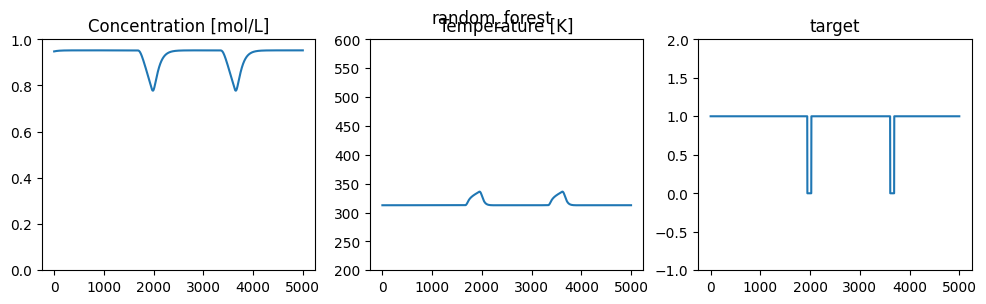

1666 new Coolant Temperature 304
1943 fix Coolant Temperature
1944 fix Coolant Temperature
1945 fix Coolant Temperature
1946 fix Coolant Temperature
1947 fix Coolant Temperature
1948 fix Coolant Temperature
1949 fix Coolant Temperature
1950 fix Coolant Temperature
1951 fix Coolant Temperature
1952 fix Coolant Temperature
1953 fix Coolant Temperature
1954 fix Coolant Temperature
1955 fix Coolant Temperature
1956 fix Coolant Temperature
1957 fix Coolant Temperature
1958 fix Coolant Temperature
1959 fix Coolant Temperature
1960 fix Coolant Temperature
1961 fix Coolant Temperature
1962 fix Coolant Temperature
1963 fix Coolant Temperature
1964 fix Coolant Temperature
1965 fix Coolant Temperature
1966 fix Coolant Temperature
1967 fix Coolant Temperature
1968 fix Coolant Temperature
1969 fix Coolant Temperature
1970 fix Coolant Temperature
1971 fix Coolant Temperature
1972 fix Coolant Temperature
1973 fix Coolant Temperature
1974 fix Coolant Temperature
1975 fix Coolant Temperature
1976 fix C

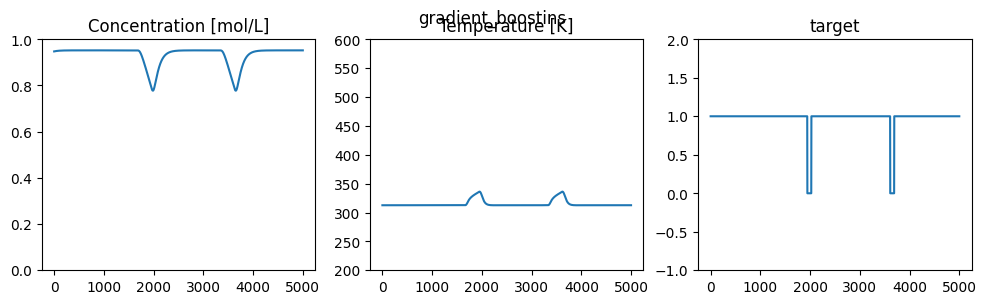

1666 new Coolant Temperature 304
1943 fix Coolant Temperature
1944 fix Coolant Temperature
1945 fix Coolant Temperature
1946 fix Coolant Temperature
1947 fix Coolant Temperature
1948 fix Coolant Temperature
1949 fix Coolant Temperature
1950 fix Coolant Temperature
1951 fix Coolant Temperature
1952 fix Coolant Temperature
1953 fix Coolant Temperature
1954 fix Coolant Temperature
1955 fix Coolant Temperature
1956 fix Coolant Temperature
1957 fix Coolant Temperature
1958 fix Coolant Temperature
1959 fix Coolant Temperature
1960 fix Coolant Temperature
1961 fix Coolant Temperature
1962 fix Coolant Temperature
1963 fix Coolant Temperature
1964 fix Coolant Temperature
1965 fix Coolant Temperature
1966 fix Coolant Temperature
1967 fix Coolant Temperature
1968 fix Coolant Temperature
1969 fix Coolant Temperature
1970 fix Coolant Temperature
1971 fix Coolant Temperature
1972 fix Coolant Temperature
1973 fix Coolant Temperature
1974 fix Coolant Temperature
1975 fix Coolant Temperature
1976 fix C

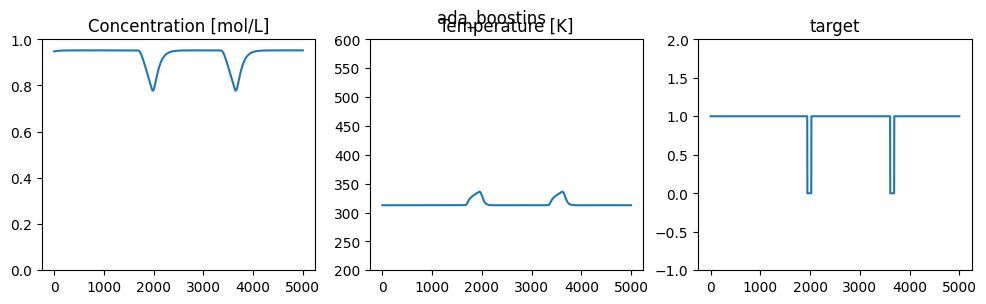

1666 new Coolant Temperature 304
1753 fix Coolant Temperature
1754 fix Coolant Temperature
1755 fix Coolant Temperature
1756 fix Coolant Temperature
1757 fix Coolant Temperature
1758 fix Coolant Temperature
1759 fix Coolant Temperature
1760 fix Coolant Temperature
1761 fix Coolant Temperature
1762 fix Coolant Temperature
1763 fix Coolant Temperature
1764 fix Coolant Temperature
1765 fix Coolant Temperature
1766 fix Coolant Temperature
1767 fix Coolant Temperature
1768 fix Coolant Temperature
1769 fix Coolant Temperature
1770 fix Coolant Temperature
1771 fix Coolant Temperature
1772 fix Coolant Temperature
1773 fix Coolant Temperature
1774 fix Coolant Temperature
1775 fix Coolant Temperature
1776 fix Coolant Temperature
1777 fix Coolant Temperature
1778 fix Coolant Temperature
1779 fix Coolant Temperature
1780 fix Coolant Temperature
1781 fix Coolant Temperature
1782 fix Coolant Temperature
1783 fix Coolant Temperature
1784 fix Coolant Temperature
1785 fix Coolant Temperature
1786 fix C

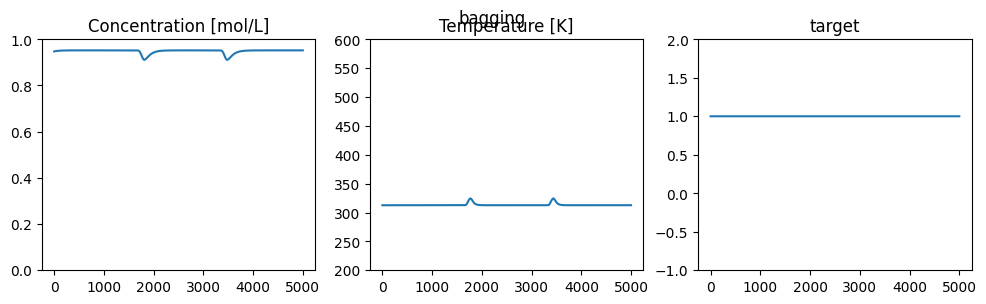

In [33]:
for title, func in models.items():
        ml_model = func(x,y)
        process_model = prepare_model()
        _x,_y, _y_pred = test_ml_model(process_model, ml_model, 5500, skip_iteration = 500, pivots=2)
        show_model_statistics(_y,_y_pred)
        show_data(_x, _y, title)